In [14]:
from google.colab import drive, files
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [15]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
zip_path = '/content/drive/My Drive/Skin Disease.v1i.multiclass.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

In [19]:
train_df = pd.read_csv('/content/train/_classes.csv')
test_df = pd.read_csv('/content/test/_classes.csv')
train_dir = '/content/train'
test_dir = '/content/test'

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='filename',
    y_col=train_df.columns[1:].tolist(),
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=test_dir,
    x_col='filename',
    y_col=test_df.columns[1:].tolist(),
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

Found 4083 validated image filenames.
Found 454 validated image filenames.


In [21]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model layers initially

In [22]:
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(17, activation='sigmoid')(x)  # 17 classes

model = Model(inputs=base_model.input, outputs=predictions)

In [23]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

def lr_schedule(epoch, lr):
    if epoch > 20:
        return lr * 0.00001  # Reduce learning rate after 20 epochs
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

In [25]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,  # Train for 30 epochs
    callbacks=[early_stopping, checkpoint, lr_scheduler]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 71s 462ms/step - accuracy: 0.0505 - loss: 1.8347 - top_k_categorical_accuracy: 0.2830 - val_accuracy: 0.0066 - val_loss: 0.4277 - val_top_k_categorical_accuracy: 0.2555 - learning_rate: 0.0010
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 55s 407ms/step - accuracy: 0.0399 - loss: 0.4516 - top_k_categorical_accuracy: 0.2845 - val_accuracy: 0.0000e+00 - val_loss: 0.3977 - val_top_k_categorical_accuracy: 0.3524 - learning_rate: 0.0010
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 55s 408ms/step - accuracy: 0.0144 - loss: 0.4256 - top_k_categorical_accuracy: 0.2857 - val_accuracy: 0.0000e+00 - val_loss: 0.3825 - val_top_k_categorical_accuracy: 0.1322 - learning_rate: 0.0010
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 55s 409ms/step - accuracy: 5.2158e-05 - loss: 0.4102 - top_k_categorical_accuracy: 0.2152 - val_accuracy: 0.0000e+00 - val_loss: 0.3809 - val_top_k_categorical_accuracy: 0.3128 - learning_rate: 0.0010
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 55s 410ms/step - accura

In [26]:
base_model.trainable = True  # Unfreeze the base model layers

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

# Fine-tune the model for an additional 10 epochs
history_fine = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,  # Fine-tune for 10 more epochs
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 123s 542ms/step - accuracy: 0.2819 - loss: 0.2428 - top_k_categorical_accuracy: 0.7139 - val_accuracy: 0.0110 - val_loss: 0.9405 - val_top_k_categorical_accuracy: 0.2445
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 48s 358ms/step - accuracy: 0.5993 - loss: 0.0656 - top_k_categorical_accuracy: 0.9919 - val_accuracy: 0.1322 - val_loss: 1.1557 - val_top_k_categorical_accuracy: 0.2181
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 48s 356ms/step - accuracy: 0.6341 - loss: 0.0532 - top_k_categorical_accuracy: 0.9971 - val_accuracy: 0.0000e+00 - val_loss: 0.9074 - val_top_k_categorical_accuracy: 0.3348
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 48s 357ms/step - accuracy: 0.6567 - loss: 0.0450 - top_k_categorical_accuracy: 0.9979 - val_accuracy: 0.0000e+00 - val_loss: 1.4269 - val_top_k_categorical_accuracy: 0.2753
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 48s 355ms/step - accuracy: 0.7254 - loss: 0.0373 - top_k_categorical_accuracy: 0.9983 - val_accuracy: 0.0044 - val_

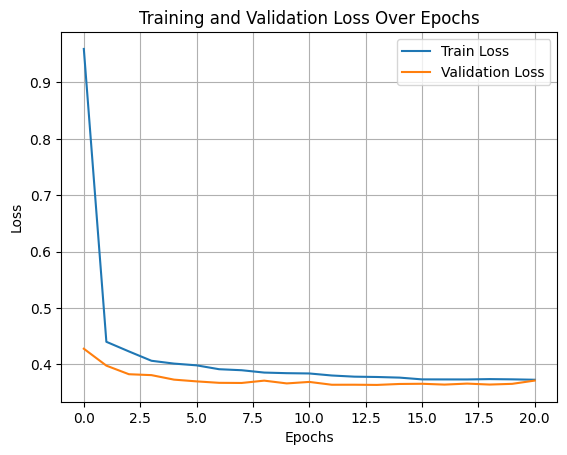

In [27]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
model.load_weights('best_model.keras')
test_loss, test_acc, top_k_acc = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy (Top-1): {test_acc}')
print(f'Top-K Accuracy (Top-5): {top_k_acc}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7526 - loss: 0.0378 - top_k_categorical_accuracy: 0.9996
Test Loss: 0.04059066250920296
Test Accuracy (Top-1): 0.7731277346611023
Top-K Accuracy (Top-5): 0.9977973699569702


In [29]:
y_true = test_generator.labels  # True labels for the test set
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary values

# Generate F1 score and classification report
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1}")

report = classification_report(y_true, y_pred, target_names=[
    "Actinic", "Atopic", "Benign", "Candidiasis", "Dermatitis", "Dermatofibroma",
    "Melanocytic", "Melanoma", "Ringworm", "Squamous", "Tinea", "Vascular",
    "Carcinoma", "Cell", "Keratosis", "Lesion", "Nevus"
])
print(report)

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 291ms/step
F1 Score: 0.9752454754929828
                precision    recall  f1-score   support

       Actinic       1.00      1.00      1.00        51
        Atopic       1.00      1.00      1.00        45
        Benign       1.00      0.98      0.99        56
   Candidiasis       1.00      1.00      1.00        60
    Dermatitis       1.00      1.00      1.00        45
Dermatofibroma       0.98      0.93      0.95        54
   Melanocytic       1.00      0.87      0.93        39
      Melanoma       1.00      1.00      1.00        44
      Ringworm       1.00      1.00      1.00        60
      Squamous       1.00      0.85      0.92        54
         Tinea       1.00      1.00      1.00        60
      Vascular       1.00      1.00      1.00        51
     Carcinoma       1.00      0.83      0.91        54
          Cell       1.00      0.87      0.93        54
     Keratosis       1.00      0.99      1.00       107
        Lesion       0.96      1.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
from google.colab import files
uploaded = files.upload()

# After uploading, the filename will be available in `uploaded.keys()`
img_path = list(uploaded.keys())[0]

Saving dr_9_9199_jpg.rf.6123b1d256b4cd58044f4f1bbccb00ab.jpg to dr_9_9199_jpg.rf.6123b1d256b4cd58044f4f1bbccb00ab.jpg


In [36]:
img_path = '/content/dr_9_9199_jpg.rf.6123b1d256b4cd58044f4f1bbccb00ab.jpg'

In [37]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Replace this with the correct path to your image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Expand to match batch size
img_array /= 255.  # Rescale the image

# Make predictions
predictions = model.predict(img_array)
print(predictions)  # This will return the probabilities for each class


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[3.5185683e-05 7.1414094e-03 2.7708456e-06 2.7251261e-05 2.3307344e-02
  2.1027609e-04 9.9310098e-05 5.1174815e-05 5.9084696e-06 1.0603532e-04
  4.6538175e-05 9.9927408e-01 3.8922313e-05 1.2329318e-04 2.8002983e-06
  9.9777120e-01 7.0542167e-04]]


In [38]:
predicted_class = np.argmax(predictions, axis=1)
print(f"Predicted class: {predicted_class}")

class_labels = [
    "Actinic", "Atopic", "Benign", "Candidiasis", "Dermatitis", "Dermatofibroma",
    "Melanocytic", "Melanoma", "Ringworm", "Squamous", "Tinea", "Vascular",
    "Carcinoma", "Cell", "Keratosis", "Lesion", "Nevus"
]
predicted_class = np.argmax(predictions, axis=1)
predicted_class_name = class_labels[predicted_class[0]]  # Assuming batch size is 1

print(f"Predicted class: {predicted_class_name}")


Predicted class: [11]
Predicted class: Vascular


In [40]:
# Save the model after training/fine-tuning
model.save('skin_disease_classifier.h5')
